In [ ]:
pip install numpy matplotlib scipy tensorflow

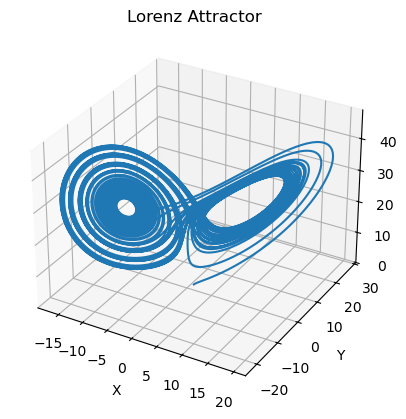

c:\Users\PC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
219/219 - 7s - 32ms/step - loss: 170.9740 - val_loss: 106.7017
Epoch 2/50
219/219 - 2s - 8ms/step - loss: 58.3463 - val_loss: 54.1537
Epoch 3/50
219/219 - 2s - 7ms/step - loss: 29.1270 - val_loss: 34.1493
Epoch 4/50
219/219 - 2s - 7ms/step - loss: 18.2842 - val_loss: 23.8812
Epoch 5/50
219/219 - 2s - 8ms/step - loss: 12.6756 - val_loss: 17.2061
Epoch 6/50
219/219 - 3s - 13ms/step - loss: 9.1644 - val_loss: 12.5861
Epoch 7/50
219/219 - 2s - 7ms/step - loss: 6.8487 - val_loss: 9.4484
Epoch 8/50
219/219 - 1s - 6ms/step - loss: 5.1627 - val_loss: 6.9777
Epoch 9/50
219/219 - 1s - 6ms/step - loss: 3.8805 - val_loss: 5.0681
Epoch 10/50
219/219 - 1s - 5ms/step - loss: 2.9017 - val_loss: 3.6531
Epoch 11/50
219/219 - 1s - 5ms/step - loss: 2.1518 - val_loss: 2.6880
Epoch 12/50
219/219 - 1s - 3ms/step - loss: 1.6114 - val_loss: 1.9227
Epoch 13/50
219/219 - 1s - 5ms/step - loss: 1.2242 - val_loss: 1.4126
Epoch 14/50
219/219 - 1s - 4ms/step - loss: 0.9482 - val_loss: 1.0633
Epoch 15/50
21

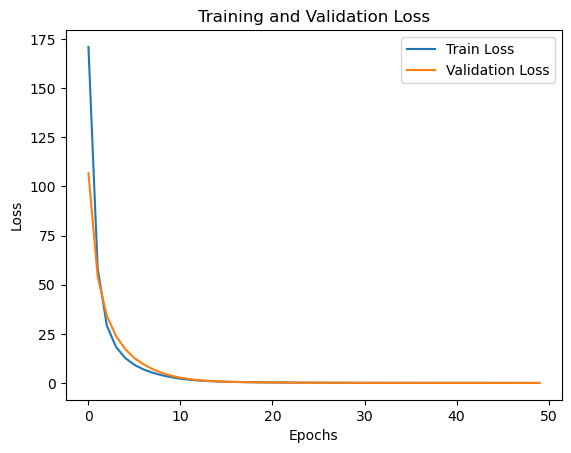

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Squared Error: 0.006875347866617615


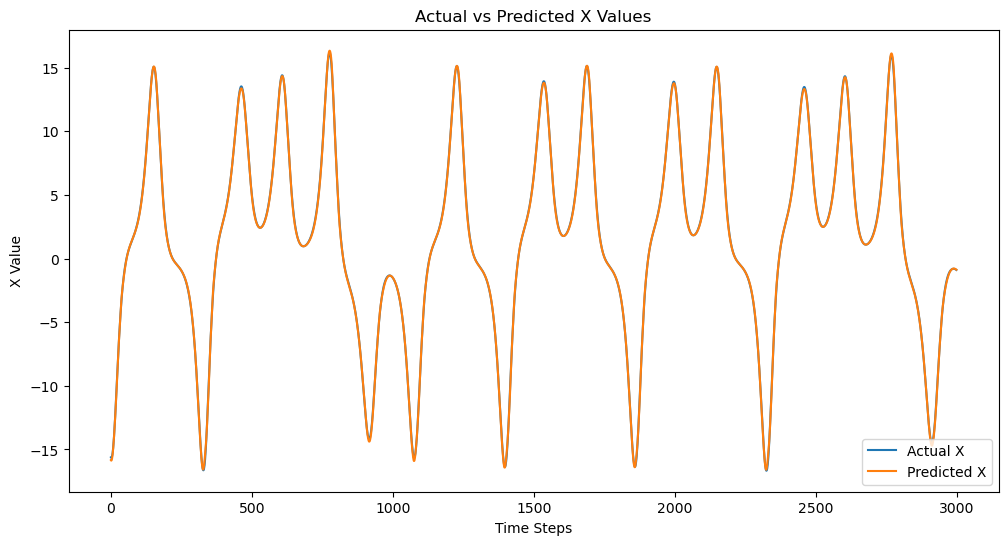

Model saved as 'lstm_lorenz_model.h5'


In [3]:
# learning_and_modeling_chaos.py
# Reproducing the paper "Learning and Modeling Chaos Using LSTM Recurrent Neural Networks"

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Step 1: Generate Lorenz System Data
def lorenz(t, state, sigma, rho, beta):
    """Lorenz system equations."""
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Parameters for the Lorenz system
sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0
initial_state = [1.0, 1.0, 1.0]  # Initial conditions
t_span = (0, 50)  # Time span
t_eval = np.linspace(0, 50, 10000)  # Time points to evaluate

# Solve the Lorenz system
sol = solve_ivp(lorenz, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval)

# Plot the Lorenz attractor
def plot_lorenz_attractor(sol):
    """Plot the Lorenz attractor in 3D."""
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol.y[0], sol.y[1], sol.y[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("Lorenz Attractor")
    plt.show()

plot_lorenz_attractor(sol)

# Step 2: Prepare Data for Training
def prepare_data(sol):
    """Prepare data for training the LSTM model."""
    X = sol.y.T  # Input features (x, y, z)
    y = np.roll(X, -1, axis=0)  # Target (next time step)
    X = X[:-1]  # Remove the last row (no target for it)
    y = y[:-1]
    return train_test_split(X, y, test_size=0.3, shuffle=False)

X_train, X_test, y_train, y_test = prepare_data(sol)

# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Step 3: Build and Train the LSTM Model
def build_lstm_model(input_shape):
    """Build an LSTM model."""
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(3))  # Output layer with 3 units (x, y, z)
    model.compile(loss='mse', optimizer='adam')
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)

# Plot training loss
def plot_training_loss(history):
    """Plot the training and validation loss."""
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_loss(history)

# Step 4: Evaluate the Model
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set."""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Plot predictions vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, 0], label='Actual X')
    plt.plot(y_pred[:, 0], label='Predicted X')
    plt.xlabel('Time Steps')
    plt.ylabel('X Value')
    plt.title('Actual vs Predicted X Values')
    plt.legend()
    plt.show()

evaluate_model(lstm_model, X_test, y_test)

# Step 5: Save the Model (Optional)
lstm_model.save('lstm_lorenz_model.h5')
print("Model saved as 'lstm_lorenz_model.h5'")